### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [65]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [66]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A' ,'e' ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'OMEGA', 'i0', 'Cuc','Cus','Toe', 'OMEGA_dot', 'omega',
       'Crc', 'Cic', 'M0', 'I_dot', 'Del_n', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Cis
Epoch_Time_of_Clock,
2017-11-01 14:00:00,-0.00000006146728992460
2017-11-01 16:00:00,-0.00000013224780559500
2017-11-01 18:00:00,-0.00000008381903171540
2017-11-01 20:00:00,0.00000004284083843230
2017-11-01 22:00:00,0.00000009313225746150


In [67]:
var_name = 'Cis'
sat_var  = 1

In [68]:

df = df.iloc[5 : , :]

In [69]:

df.head(7)

,Cis
Epoch_Time_of_Clock,
2017-11-02 12:00:00,0.00000014528632164000
2017-11-02 14:00:00,-0.00000008381903171540
2017-11-02 16:00:00,-0.00000015273690223700
2017-11-02 18:00:00,-0.00000009126961231230
2017-11-02 20:00:00,0.00000005215406417850
2017-11-02 22:00:00,0.00000011175870895400
2017-11-03 12:00:00,0.00000012665987014800


# Enter number of entries per day

In [70]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [71]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [72]:
train = df.copy()[df.index < valid_start_dt][[var_name ]]
train.head()

,Cis
Epoch_Time_of_Clock,
2017-11-02 12:00:00,0.00000014528632164000
2017-11-02 14:00:00,-0.00000008381903171540
2017-11-02 16:00:00,-0.00000015273690223700
2017-11-02 18:00:00,-0.00000009126961231230
2017-11-02 20:00:00,0.00000005215406417850


In [73]:
train.tail(6)

,Cis
Epoch_Time_of_Clock,
2017-11-20 12:00:00,-0.00000007823109626770
2017-11-20 14:00:00,-0.00000011920928955100
2017-11-20 16:00:00,-0.00000012665987014800
2017-11-20 18:00:00,0.00000007078051567080
2017-11-20 20:00:00,0.00000013038516044600
2017-11-20 22:00:00,0.00000009685754776000


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [74]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[[var_name]] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [75]:
tensor_structure = {'X':(range(-T+1, 1), [var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), [var_name])} ,freq = None)

In [76]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00  1.41815848489353668604 -1.13082954046999306641   
2017-11-03 12:00:00 -1.13082954046999306641 -1.69281115235454704404   
2017-11-03 14:00:00 -1.69281115235454704404 -0.78962641896157592658   
2017-11-03 16:00:00 -0.78962641896157592658  0.85617687300036227072   
2017-11-03 18:00:00  0.85617687300036227072  1.45830002859495810874   
2017-11-03 20:00:00  1.45830002859495810874  0.99667227597365581904   
2017-11-03 22:00:00  0.99667227597365581904 -1.33153725899865182924   
2017-11-04 12:00:00 -1.33153725899865182924 -1.57238652123950717332   
2017-11-04 14:00:00 -1.57238652123950717332 -0.46849406931033460433   
2017-11-04 16:00:00 -0.46849406931033460433  1.13716767894048431664   
2017-11-04 18:00:00  1.13716767894048431664  1.49844157230715513407   
2017-11-04 20:00:00  1.49844157230715513407  0.51497375149625512769   
2017-11-04 22:00:00  0.51497375149625512769 -1.33153725899865182924   
2017-11-05 12:00:00 -1.33153725899865182924 -1.29139571528645480392   
2017-11-05 14:00:00 -1.29139571528645480392 -0.14736171965909328208   
2017-11-05 16:00:00 -0.14736171965909328208  1.27766308191701027930   
2017-11-05 18:00:00  1.27766308191701027930  1.35794616933062894937   
2017-11-05 20:00:00  1.35794616933062894937  0.17377062999214798467   
2017-11-05 22:00:00  0.17377062999214798467 -1.19104185602212564454   
2017-11-06 12:00:00 -1.19104185602212564454 -1.03047568119488852645   
2017-11-06 14:00:00 -1.03047568119488852645 -0.00686631668676950923   
2017-11-06 16:00:00 -0.00686631668676950923  1.23752153821558885660   
2017-11-06 18:00:00  1.23752153821558885660  1.09702613523906267190   
2017-11-06 20:00:00  1.09702613523906267190  0.05334599887279782571   
2017-11-06 22:00:00  0.05334599887279782571 -1.01040490934633275799   
2017-11-07 12:00:00 -1.01040490934633275799 -0.95019259378665787974   
2017-11-07 14:00:00 -0.95019259378665787974 -0.06707863224655234713   
2017-11-07 16:00:00 -0.06707863224655234713  1.07695536338619679562   
2017-11-07 18:00:00  1.07695536338619679562  0.89631841670717149473   
2017-11-07 20:00:00  0.89631841670717149473  0.09348754257917606114   
...                                     ...                     ...   
2017-11-15 12:00:00 -1.31146648714794089585 -0.50863561301714388385   
2017-11-15 14:00:00 -0.50863561301714388385  0.65546915446847120457   
2017-11-15 16:00:00  0.65546915446847120457  1.01674304782652180634   
2017-11-15 18:00:00  1.01674304782652180634  0.53504452334912100397   
2017-11-15 20:00:00  0.53504452334912100397 -0.88998027822806013987   
2017-11-15 22:00:00 -0.88998027822806013987 -1.15090031232070399980   
2017-11-16 12:00:00 -1.15090031232070399980 -0.56884792857681887313   
2017-11-16 14:00:00 -0.56884792857681887313  0.57518606705593022799   
2017-11-16 16:00:00  0.57518606705593022799  0.97660150411971247131   
2017-11-16 18:00:00  0.97660150411971247131  0.65546915446847120457   
2017-11-16 20:00:00  0.65546915446847120457 -0.76955564710871005030   
2017-11-16 22:00:00 -0.76955564710871005030 -1.03047568119488852645   
2017-11-17 12:00:00 -1.03047568119488852645 -0.74948487525476659155   
2017-11-17 14:00:00 -0.74948487525476659155  0.53504452334912100397   
2017-11-17 16:00:00  0.53504452334912100397  1.01674304782652180634   
2017-11-17 18:00:00  1.01674304782652180634  0.85617687300036227072   
2017-11-17 20:00:00  0.85617687300036227072 -0.68927255969509160227   
2017-11-17 22:00:00 -0.68927255969509160227 -1.01040490934633275799   
2017-11-18 12:00:00 -1.01040490934633275799 -0.99033413749346699273   
2017-11-18 14:00:00 -0.99033413749346699273  0.57518606705593022799   
2017-11-18 16:00:00  0.57518606705593022799  1.15723845080197040858   
2017-11-18 18:00:00  1.1

In [77]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [78]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[var_name]]
valid[[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.05054645305637461838 -1.49210343382588872529   
2017-11-22 12:00:00 -1.49210343382588872529 -1.13082954046999306641   
2017-11-22 14:00:00 -1.13082954046999306641  1.09702613523906267190   
2017-11-22 16:00:00  1.09702613523906267190  1.53858311600857655677   
2017-11-22 18:00:00  1.53858311600857655677  0.65546915446847120457   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.13082954046999306641  1.09702613523906267190   
2017-11-22 12:00:00  1.09702613523906267190  1.53858311600857655677   
2017-11-22 14:00:00  1.53858311600857655677  0.65546915446847120457   
2017-11-22 16:00:00  0.65546915446847120457 -1.09068799675779604108   
2017-11-22 18:00:00 -1.09068799675779604108 -1.51217420567659965869   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  1.53858311600857655677  0.65546915446847120457   
2017-11-22 12:00:00  0.65546915446847120457 -1.09068799675779604108   
2017-11-22 14:00:00 -1.09068799675779604108 -1.51217420567659965869   
2017-11-22 16:00:00 -1.51217420567659965869 -0.91005105008092612717   
2017-11-22 18:00:00 -0.91005105008092612717  1.15723845080197040858   

tensor                                    X                          \
feature                                 Cis                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.93012182193379200346 -1.39174957456155956592   
2017-11-22 12:00:00 -1.39174957456155956592 -1.29139571528645480392   
2017-11-22 14:00:00 -1.29139571528645480392  0.97660150411971247131   
2017-11-22 16:00:00  0.97660150411971247131  1.53858311600857655677   
2017-11-22 18:00:00  1.53858311600857655677  0.89631841670717149473   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.29139571528645480392  0.97660150411971247131   
2017-11-22 12:00:00  0.97660150411971247131  1.53858311600857655677   
2017-11-22 14:00:00  1.53858311600857655677  0.89631841670717149473   
2017-11-22 16:00:00  0.89631841670717149473 -1.05054645305637461838   
2017-11-22 18:00:00 -1.05054645305637461838 -1.49210343382588872529   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-21 22:00:00  1.53858311600857655677  0.89631841670717149473  
2017-11-22 12:00:00  0.89631841670717149473 -1.05054645305637461838  
2017-11-22 14:00:00 -1.05054645305637461838 -1.49210343382588872529  
2017-11-22 16:00:00 -1.49210343382588872529 -1.13082954046999306641  
2017-11-22 18:00:00 -1.13082954046999306641  1.09702613523906267190

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [79]:
#Image('./images/simple_encoder_decoder.png')

In [80]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [81]:
LATENT_DIM = 64
BATCH_SIZE = 8
EPOCHS = 10

In [82]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [83]:
model.compile(optimizer='RMSprop', loss='mse')

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [85]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [86]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [87]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/10
103/103 [==============================] - 2s 18ms/step - loss: 0.8981 - val_loss: 1.1710
Epoch 2/10
103/103 [==============================] - 0s 1ms/step - loss: 0.7842 - val_loss: 0.9777
Epoch 3/10
103/103 [==============================] - 0s 2ms/step - loss: 0.6447 - val_loss: 0.8041
Epoch 4/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5713 - val_loss: 0.7433
Epoch 5/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5471 - val_loss: 0.7049
Epoch 6/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5281 - val_loss: 0.6599
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5014 - val_loss: 0.6047
Epoch 8/10
103/103 [==============================] - 0s 2ms/step - loss: 0.4642 - val_loss: 0.5431
Epoch 9/10
103/103 [==============================] - 0s 2ms/step - loss: 0.4095 - val_loss: 0.4909
Epoch 10/10
103/103 [==============================] -

In [88]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [89]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][[var_name]]
test[[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.72941410340190082628 -1.21111262788361173648   
2017-11-26 12:00:00 -1.21111262788361173648 -0.52870638487000964911   
2017-11-26 14:00:00 -0.52870638487000964911  0.91638918856003737101   
2017-11-26 16:00:00  0.91638918856003737101  1.01674304782652180634   
2017-11-26 18:00:00  1.01674304782652180634  0.53504452334912100397   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.52870638487000964911  0.91638918856003737101   
2017-11-26 12:00:00  0.91638918856003737101  1.01674304782652180634   
2017-11-26 14:00:00  1.01674304782652180634  0.53504452334912100397   
2017-11-26 16:00:00  0.53504452334912100397 -0.62906024413649397342   
2017-11-26 18:00:00 -0.62906024413649397342 -1.21111262788361173648   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  1.01674304782652180634  0.53504452334912100397   
2017-11-26 12:00:00  0.53504452334912100397 -0.62906024413649397342   
2017-11-26 14:00:00 -0.62906024413649397342 -1.21111262788361173648   
2017-11-26 16:00:00 -1.21111262788361173648 -0.66920178784222572599   
2017-11-26 18:00:00 -0.66920178784222572599  0.73575224188208965259   

tensor                                    X                          \
feature                                 Cis                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.88998027822806013987 -1.31146648714794089585   
2017-11-26 12:00:00 -1.31146648714794089585 -0.52870638487000964911   
2017-11-26 14:00:00 -0.52870638487000964911  1.05688459153225355891   
2017-11-26 16:00:00  1.05688459153225355891  1.17730922265268111992   
2017-11-26 18:00:00  1.17730922265268111992  0.35440757667117328555   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.52870638487000964911  1.05688459153225355891   
2017-11-26 12:00:00  1.05688459153225355891  1.17730922265268111992   
2017-11-26 14:00:00  1.17730922265268111992  0.35440757667117328555   
2017-11-26 16:00:00  0.35440757667117328555 -0.72941410340190082628   
2017-11-26 18:00:00 -0.72941410340190082628 -1.21111262788361173648   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-25 22:00:00  1.17730922265268111992  0.35440757667117328555  
2017-11-26 12:00:00  0.35440757667117328555 -0.72941410340190082628  
2017-11-26 14:00:00 -0.72941410340190082628 -1.21111262788361173648  
2017-11-26 16:00:00 -1.21111262788361173648 -0.52870638487000964911  
2017-11-26 18:00:00 -0.52870638487000964911  0.91638918856003737101

In [30]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00  0.35790134500244308313 -0.73778403245357493390   
2017-11-25 22:00:00 -0.73778403245357493390 -1.22475531132775761201   
2017-11-26 12:00:00 -1.22475531132775761201 -0.53487933292484390879   
2017-11-26 14:00:00 -0.53487933292484390879  0.92603450368245354696   
2017-11-26 16:00:00  0.92603450368245354696  1.02748685344736379044   
2017-11-26 18:00:00  1.02748685344736379044  0.54051557457753829361   
2017-11-26 20:00:00  0.54051557457753829361 -0.63633168268975404125   
2017-11-26 22:00:00 -0.63633168268975404125 -1.22475531132775761201   
2017-11-27 12:00:00 -1.22475531132775761201 -0.67691262259484663577   
2017-11-27 14:00:00 -0.67691262259484663577  0.74342027410735833648   
2017-11-27 16:00:00  0.74342027410735833648  0.96661544358863538129   
2017-11-27 18:00:00  0.96661544358863538129  0.84487262387117922913   
2017-11-27 20:00:00  0.84487262387117922913 -0.65662215264230039402   
2017-11-27 22:00:00 -0.65662215264230039402 -1.36678860099122401195   
2017-11-28 12:00:00 -1.36678860099122401195 -0.90010779207721303141   
2017-11-28 14:00:00 -0.90010779207721303141  0.64196792434244831504   
2017-11-28 16:00:00  0.64196792434244831504  1.00719638349481721562   
2017-11-28 18:00:00  1.00719638349481721562  1.12893920321118446104   
2017-11-28 20:00:00  1.12893920321118446104 -0.83923638221848473329   
2017-11-28 22:00:00 -0.83923638221848473329 -1.58998377047794803296   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -1.22475531132775761201 -0.53487933292484390879   
2017-11-25 22:00:00 -0.53487933292484390879  0.92603450368245354696   
2017-11-26 12:00:00  0.92603450368245354696  1.02748685344736379044   
2017-11-26 14:00:00  1.02748685344736379044  0.54051557457753829361   
2017-11-26 16:00:00  0.54051557457753829361 -0.63633168268975404125   
2017-11-26 18:00:00 -0.63633168268975404125 -1.22475531132775761201   
2017-11-26 20:00:00 -1.22475531132775761201 -0.67691262259484663577   
2017-11-26 22:00:00 -0.67691262259484663577  0.74342027410735833648   
2017-11-27 12:00:00  0.74342027410735833648  0.96661544358863538129   
2017-11-27 14:00:00  0.96661544358863538129  0.84487262387117922913   
2017-11-27 16:00:00  0.84487262387117922913 -0.65662215264230039402   
2017-11-27 18:00:00 -0.65662215264230039402 -1.36678860099122401195   
2017-11-27 20:00:00 -1.36678860099122401195 -0.90010779207721303141   
2017-11-27 22:00:00 -0.90010779207721303141  0.64196792434244831504   
2017-11-28 12:00:00  0.64196792434244831504  1.00719638349481721562   
2017-11-28 14:00:00  1.00719638349481721562  1.12893920321118446104   
2017-11-28 16:00:00  1.12893920321118446104 -0.83923638221848473329   
2017-11-28 18:00:00 -0.83923638221848473329 -1.58998377047794803296   
2017-11-28 20:00:00 -1.58998377047794803296 -1.08272202165339770374   
2017-11-28 22:00:00 -1.08272202165339770374  0.66225839429499466782   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00  0.92603450368245354696  1.02748685344736379044   
2017-11-25 22:00:00  1.02748685344736379044  0.54051557457753829361   
2017-11-26 12:00:00  0.54051557457753829361 -0.63633168268975404125   
2017-11-26 14:00:00 -0.63633168268975404125 -1.22475531132775761201   
2017-11-26 16:00:00 -1

In [31]:
test_inputs.dataframe.shape

(20, 12)

In [32]:
predictions = model.predict(test_inputs['X'])

In [33]:
predictions

array([[-0.54584664 , -0.9782025  , -1.0197015  , -0.49368575 ,
         0.49618354 ,  1.5289083  ],
       [-0.4035408  , -0.5263744  , -0.29324788 ,  0.22797686 ,
         0.86141014 ,  1.4364415  ],
       [ 0.12966743 ,  0.325228   ,  0.48480836 ,  0.48829734 ,
         0.26032543 , -0.22129324 ],
       [ 0.55700403 ,  0.82683694 ,  0.73529947 ,  0.25969273 ,
        -0.5439369  , -1.5218698  ],
       [ 0.4539236  ,  0.53608435 ,  0.28215933 , -0.24822241 ,
        -0.9409612  , -1.6493515  ],
       [-0.08456047 , -0.37823263 , -0.7000981  , -0.82487136 ,
        -0.5081043  ,  0.3600414  ],
       [-0.47851893 , -0.877868   , -0.9413057  , -0.4814457  ,
         0.45290354 ,  1.4859209  ],
       [-0.39605242 , -0.53203267 , -0.31943792 ,  0.19401333 ,
         0.8413861  ,  1.4424442  ],
       [ 0.08857189 ,  0.26029366 ,  0.42770934 ,  0.47500703 ,
         0.31912756 , -0.07667746 ],
       [ 0.5274751  ,  0.7925374  ,  0.7157515  ,  0.26493043 ,
        -0.51496613 , -1.48

In [34]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-25 20:00:00  t+1 -0.00000005502349740863  0.00000002793967723850
1 2017-11-25 22:00:00  t+1 -0.00000004195996050408 -0.00000007264316082000
2 2017-11-26 12:00:00  t+1  0.00000000698802882535 -0.00000011734664440200
3 2017-11-26 14:00:00  t+1  0.00000004621710795787 -0.00000005401670932770
4 2017-11-26 16:00:00  t+1  0.00000003675442681345  0.00000008009374141690
              timestamp    h              prediction                  actual
115 2017-11-28 14:00:00  t+6 -0.00000013930359821814 -0.00000015087425708800
116 2017-11-28 16:00:00  t+6 -0.00000016594323409354 -0.00000010430812835700
117 2017-11-28 18:00:00  t+6 -0.00000001788258505965  0.00000005587935447690
118 2017-11-28 20:00:00  t+6  0.00000011570629458278  0.00000010430812835700
119 2017-11-28 22:00:00  t+6  0.00000013962153142789  0.00000011175870895400
(120, 4)


In [35]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.15770297266526031588
t+2   -0.02811888146105668770
t+3    0.05398625661542184873
t+4    0.16791005262237546081
t+5    0.12931457080913630331
t+6    0.09401017418390100744
Name: APE, dtype: float64

In [36]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

4.771829182442468e-08

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

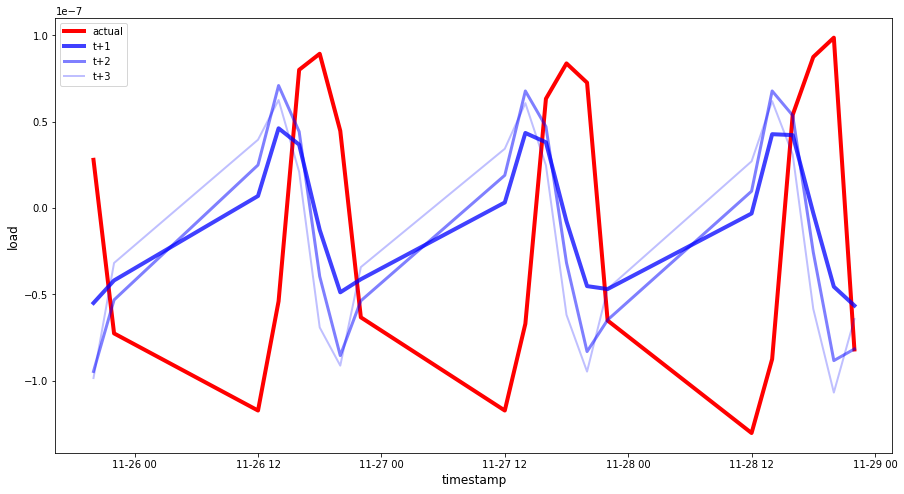

In [37]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [38]:
a = df.iloc[156:162  , :]
a

,Cis
Epoch_Time_of_Clock,
2017-11-28 22:00:00,0.00000009872019290920
2017-11-29 12:00:00,-0.00000008195638656620
2017-11-29 14:00:00,-0.00000015087425708800
2017-11-29 16:00:00,-0.00000010430812835700
2017-11-29 18:00:00,0.00000005587935447690
2017-11-29 20:00:00,0.00000010430812835700


In [39]:
new_df = pd.DataFrame()

In [40]:
columns = [var_name] 

In [41]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [42]:
new_df = new_df.dropna( how = 'any')

In [43]:
new_df

,Cis
Epoch_Time_of_Clock,
2017-11-28 22:00:00,0.00000009872019290920
2017-11-29 12:00:00,-0.00000008195638656620
2017-11-29 14:00:00,-0.00000015087425708800
2017-11-29 16:00:00,-0.00000010430812835700
2017-11-29 18:00:00,0.00000005587935447690
2017-11-29 20:00:00,0.00000010430812835700


In [44]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [45]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [46]:
date

DatetimeIndex(['2017-11-29 22:00:00', '2017-11-30 12:00:00',
               '2017-11-30 14:00:00', '2017-11-30 16:00:00',
               '2017-11-30 18:00:00', '2017-11-30 20:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq=None)

In [47]:
new_df.index= date

In [48]:
new_df.columns

Index(['Cis'], dtype='object')

In [49]:
print(new_df)
print(new_df.columns)

                                        Cis
Epoch_Time_of_Clock                        
2017-11-29 22:00:00  0.00000009872019290920
2017-11-30 12:00:00 -0.00000008195638656620
2017-11-30 14:00:00 -0.00000015087425708800
2017-11-30 16:00:00 -0.00000010430812835700
2017-11-30 18:00:00  0.00000005587935447690
2017-11-30 20:00:00  0.00000010430812835700
Index(['Cis'], dtype='object')


In [50]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Cis
Epoch_Time_of_Clock                        
2017-11-29 22:00:00  1.12893920321118446104
2017-11-30 12:00:00 -0.83923638221848473329
2017-11-30 14:00:00 -1.58998377047794803296
2017-11-30 16:00:00 -1.08272202165339770374
2017-11-30 18:00:00  0.66225839429499466782


In [51]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                          \
feature                                Cis                           
time step                              t-5                     t-4   
Epoch_Time_of_Clock                                                  
2017-11-30 20:00:00 1.12893920321118446104 -0.83923638221848473329   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-30 20:00:00 -1.58998377047794803296 -1.08272202165339770374   

tensor                                                             
feature                                                            
time step                              t-1                      t  
Epoch_Time_of_Clock                                                
2017-11-30 20:00:00 0

In [52]:
predictions = model.predict(inputs['X'])

In [53]:
predictions

array([[-0.4999359  , -1.0388118  , -1.2853475  , -0.9517769  ,
         0.021345638,  1.2774955  ]], dtype=float32)

In [54]:
print(predictions.shape)


(1, 6)


In [55]:
results = predictions[-1, :]

In [56]:
results

array([-0.4999359  , -1.0388118  , -1.2853475  , -0.9517769  ,
        0.021345638,  1.2774955  ], dtype=float32)

In [57]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Cis
0,-0.49993589520454406738
1,-1.03881180286407470703
2,-1.28534746170043945312
3,-0.95177692174911499023
4,0.02134563773870468140
5,1.27749550342559814453


In [58]:
res_df.index = date
res_df

,Cis
Epoch_Time_of_Clock,
2017-11-29 22:00:00,-0.49993589520454406738
2017-11-30 12:00:00,-1.03881180286407470703
2017-11-30 14:00:00,-1.28534746170043945312
2017-11-30 16:00:00,-0.95177692174911499023
2017-11-30 18:00:00,0.02134563773870468140
2017-11-30 20:00:00,1.27749550342559814453


In [59]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [60]:
# final generated ouput
res_df

,Cis
Epoch_Time_of_Clock,
2017-11-29 22:00:00,-0.00000005080893572540
2017-11-30 12:00:00,-0.00000010027721231154
2017-11-30 14:00:00,-0.00000012290894346734
2017-11-30 16:00:00,-0.00000009228750030843
2017-11-30 18:00:00,-0.00000000295580493415
2017-11-30 20:00:00,0.00000011235751173899


In [63]:
res_df.to_csv('SA1_Cis.csv')